<a href="https://colab.research.google.com/github/Vihaan3/Karpathy-Exercises/blob/main/Karpathy_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I highly recommend you follow along with this in Colab, even if you don't plan to run anything. The formatting as a plain Jupyter notebook file is all clunky, but you can collapse and expand the sections in Colab.  

---



In [ ]:
import torch
import torch.nn.functional as F

### Makemore Part 1

In [ ]:
words = open('/content/names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
g = torch.Generator().manual_seed(2147483647)

#### A pared down version of the neural network in the original video.

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

print(loss.item())

3.7686190605163574
2.696505546569824
2.5822560787200928
2.5413522720336914
2.52126407623291
2.509854555130005
2.5027060508728027
2.4978790283203125
2.4944381713867188
2.4918932914733887
2.4901304244995117


In [ ]:
for i in range(5):

  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


Loss: 2.49

Text Generated:
- junide.
- janasah.
- p.
- cfay.
- a.

#### E01: Trigram
I wasn't sure at first whether increasing the right way to go was increasing the size of the input dimension or adding another dimension so I decided to try both. Also, note that my code here is meant to resemble Andrej Karpathy's, which is intentonally a little bit hacky for educational purposes. This is not what a "production" implementation would look like.

##### V1: Additional Dimension

In [ ]:
import einops

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.', '.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append((ix1, ix2))
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() // 2 # dividing by 2 now because the shape of xs has changed
print('number of examples: ', num)

W1 = torch.randn((27, 27, 27), generator=g, requires_grad=True) # 3D now

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs[:, 0], num_classes=27).float() # character 1
  xenc2 = F.one_hot(xs[:, 1], num_classes=27).float() # character 2
  logits = einops.einsum(xenc, W1, xenc2, "b i, i j k, b j -> b k") # you might have to ask GPT about this line. Understand what's happening but don't stress it, it'll make more sense soon.
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W1**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W1.grad = None # set to zero the gradient
  loss.backward()

  # update
  W1.data += -50 * W1.grad

print(loss.item())

3.6517415046691895
2.8801517486572266
2.6203973293304443
2.471735715866089
2.373619794845581
2.3028182983398438
2.2486462593078613
2.205559015274048
2.1703648567199707
2.1410269737243652
2.1184768676757812


In [ ]:
for i in range(5):

  out = []
  # couldn't decide on good var names so I thought I would be funny
  uno = 0
  dos = 0
  while True:

    xenc = F.one_hot(torch.tensor(uno), num_classes=27).float().unsqueeze(0)
    xenc2 = F.one_hot(torch.tensor(dos), num_classes=27).float().unsqueeze(0)
    logits = einops.einsum(xenc, W1, xenc2, "b i, i j k, b j -> b k")
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    uno = dos
    dos = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[dos])
    if dos == 0:
      break
  print(''.join(out))

ni.
makestobfzwruvbvjxpxdznleanczqwmdemyw.
mkzdnseira.
na.
umjoebvsdfyhoujfodpmvuhdgdohupy.


Loss: 2.12

Text Generated
- coud
- qipny
- hafijcpydhrdqzieqiupfdcaanvinegnhiyah
- dae
- hatea

Lower loss but also lower quality outputs than the original. Seems like overfitting.

Curiously, when I train for 1000 steps instead, I get these results:

Loss: 1.49

Text Generated
- ouwade
- ilyasid
- prelay
- ocnzi
- ohr

These seem much higher quality than the original.  

##### V2: Bigger input dimension

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.', '.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append((ix1, ix2))
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() // 2 # dividing by 2 now because the shape of xs has changed
print('number of examples: ', num)

W2 = torch.randn((27*2, 27), generator=g, requires_grad=True) # still 2D but now the input dimension is double

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  '''Edit: a cleaner implementation would be:
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc.view(-1, 27*2) @ W2
  '''
  xenc = F.one_hot(xs[:, 0], num_classes=27).float() # character 1
  xenc2 = F.one_hot(xs[:, 1], num_classes=27).float() # character 2
  xcat = torch.cat ((xenc, xenc2), 1)
  logits = xcat @ W2
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W2**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W2.grad = None # set to zero the gradient
  loss.backward()

  # update
  W2.data += -50 * W2.grad

print(loss.item())

4.5374555587768555
2.16996693611145
2.063832998275757
2.020979404449463
1.9984627962112427
1.9848086833953857
1.9757133722305298
1.9692426919937134
1.9644166231155396
1.960689663887024
1.958001732826233


In [ ]:
for i in range(5):

  out = []
  # couldn't decide on good var names so I thought I would be funny
  uno = 0
  dos = 0
  while True:

    xenc = F.one_hot(torch.tensor(uno), num_classes=27).float().unsqueeze(0)
    xenc2 = F.one_hot(torch.tensor(dos), num_classes=27).float().unsqueeze(0)
    xcat = torch.cat((xenc, xenc2), 1)
    logits = xcat @ W2
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    uno = dos
    dos = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[dos])
    if dos == 0:
      break
  print(''.join(out))

.
.
mefilayniylenn.
.
.


Loss: 1.95

Text Generated:
- blank
- dena
- blank
- blank
- blank

Much lower loss but also lower quality generations.

#### E02: Splitting
Basic implementation of the splitting. Play around by yourself to answer Andrej Karpathy's question.

In [ ]:
import random

random.shuffle(words)

num_words = len(words)
train_split = int(0.8*num_words)
dev_split = int(0.9*num_words)

train_words = words[:train_split]
dev_words = words[train_split:dev_split]
test_words = words[dev_split:]

print(f"Train Size: {len(train_words)}")
print(f"Dev Size: {len(dev_words)}")
print(f"Test Size: {len(test_words)}")

Train Size: 25626
Dev Size: 3203
Test Size: 3204


#### E05: F.cross_entropy


In [ ]:
# From the original. You can turn snippet 1 into snippet 2 using F.cross_entropy
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

# F.cross_entropy
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean()

# Why you want to use F.cross_entropy instead: https://youtu.be/TCH_1BHY58I?t=1979

### Makemore Part 2: MLP

#### E03

### Makemore Part 3: Activations and Gradients, Batchnorm

Not bothering too much with splits here for convenience.

#### Setup

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [ ]:
X, Y = [], []
block_size = 3
n_embd = 10
n_hidden = 100
block_size = 3
vocab_size = len(itos)

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


#### E01

In [ ]:
# MLP Setup
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
C = torch.randn((vocab_size, n_embd),            generator=g)
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True
  p.data = torch.zeros_like(p.data)

47024


In [ ]:
# MLP Training
batch_size = 32
ud = []
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  Xb, Yb = X[ix], Y[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  if i % 100 == 0:
    print(loss.item())

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

3.295837163925171
3.044875144958496
2.9702932834625244
2.840195894241333
3.0619606971740723
2.819377899169922
3.093287467956543
2.6854422092437744
2.6405556201934814
2.8148913383483887


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

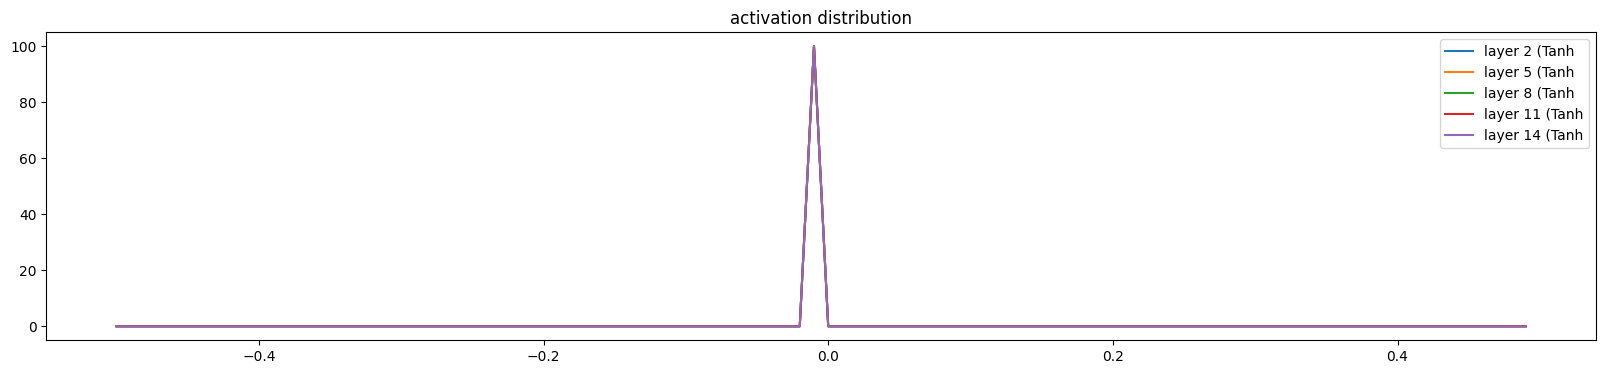

In [ ]:
# Inspect Activations
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

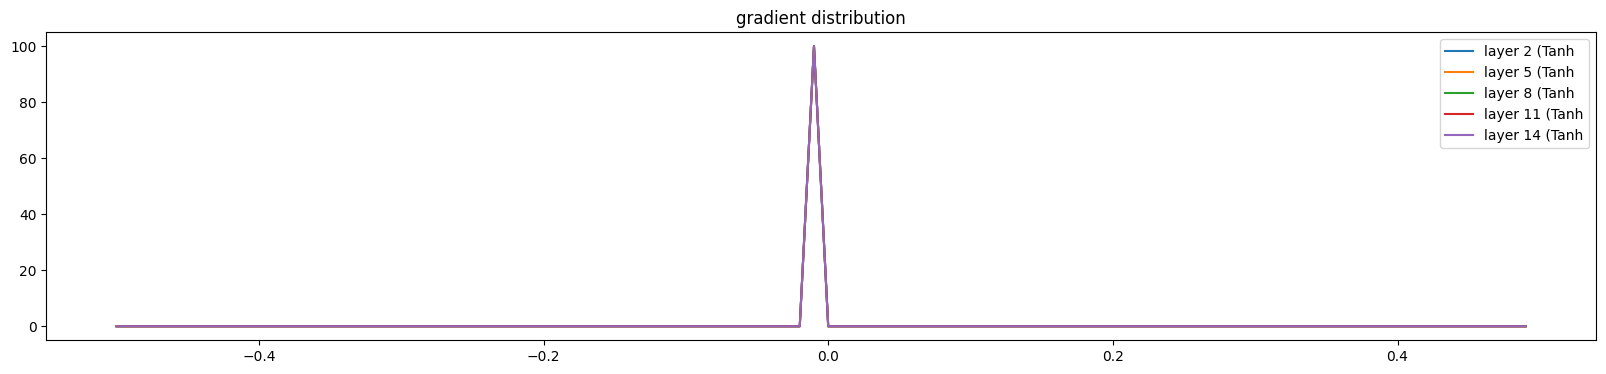

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
parameters

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

The only updates are in the last layer due to the loss calculation. This is where the "partial" training is happening.

#### E02

Folding did not work :( I'm definitely making some stupid error here.

In [ ]:
# MLP Setup
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
network = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden)
]

parameters = [C] + [p for layer in network for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

23870


In [ ]:
# MLP Training
batch_size = 32
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  Xb, Yb = X[ix], Y[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# MLP Eval 1
@torch.no_grad()
def split_loss():
  x, y = X, Y
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(loss.item())

# put layers into eval mode
for layer in network:
  layer.training = False
split_loss()

2.5595736503601074


In [ ]:
# Fold function
def fold_batchnorm_into_linear(linear, batchnorm):
    batchnorm.training = False

    # Get parameters
    gamma = batchnorm.gamma
    beta = batchnorm.beta
    running_mean = batchnorm.running_mean
    running_var = batchnorm.running_var
    eps = batchnorm.eps
    W = linear.weight
    b = linear.bias if linear.bias is not None else torch.zeros_like(beta)

    # Calculate folded parameters
    scale = gamma / torch.sqrt(running_var + eps)
    W_folded = W * scale
    b_folded = (b - running_mean) * scale + beta

    # Create new linear layer
    folded_linear = Linear(W.shape[0], W.shape[1], bias=True)

    # Assign folded parameters
    folded_linear.weight = W_folded
    folded_linear.bias = b_folded

    return folded_linear

In [ ]:
#folding
import torch.nn as nn

network[0] = fold_batchnorm_into_linear(network[0], network[1])
network[3] = fold_batchnorm_into_linear(network[3], network[4])
network[6] = fold_batchnorm_into_linear(network[6], network[7])
network[2] = nn.Identity()
network[5] = nn.Identity()

parameters = [C] + [p for layer in network for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

24170


In [ ]:
# MLP Eval 2
@torch.no_grad()
def split_loss():
  x, y = X, Y
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(loss.item())

for layer in network:
  layer.training = False
split_loss()

5.05037784576416
5.05037784576416


I get different losses :(.

### GPT

#### EX2
I started with addition and added everything else once I got that to work.

Addition: Took surprisingly longer than I thought (3-4 hours of messing around with different ideas until I actually got something that felt reasonable, and then another 2-3 hours of debugging as I realized that it wasn't reasonable at all). I learned a lot about all sorts of little things to watch out for during future implementations. There was a point where my model was taking 110k iterations to learn single-digit addition (because, as I later discovered, the saturation was ~80%).

I did my best to follow the structure of the code AK used in the video, but I have a cleaner version in the gptaddition.py file in this repo.

General: The outputs look semi-reasonable (you can see that the model is pretty close), and addition and subtraction are definitely doing fairly well. I messed around with several different ways to try to improve results, but I think it might just need a lot more training time.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

# hyperparameters
batch_size = 128
num_digits = 1
block_size = 3*num_digits + 3
max_iters = 50000
eval_interval = 1000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
n_embd = 128*2
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = 0


vocab = '0123456789+-/*='
vocab_size = len(vocab) + 1
stoi = { ch:i for i,ch in enumerate(vocab) }
itos = { i:ch for i,ch in enumerate(vocab) }
PAD_TOKEN = vocab_size - 1
stoi['P'] = PAD_TOKEN
itos[PAD_TOKEN] = 'P'
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [2]:
# Problem Generation Function
def generate_addition_problem(digits=num_digits):
  num_1 = random.randint(0, 10**digits -1)
  num_2 = random.randint(0, 10**digits -1)

  problem = f"{num_1}+{num_2}="
  answer = str(num_1+num_2)
  if len(answer) < digits + 1:
    answer = '0'+answer
  return problem, answer[::-1]

In [3]:
def generate_subtraction_problem(digits=num_digits):
    num_1 = random.randint(10**(digits-1), 10**digits - 1)
    num_2 = random.randint(0, num_1)  # num_2 <= num_1 for now

    problem = f"{num_1}-{num_2}="
    answer = str(num_1 - num_2)
    if len(answer) < digits + 1:
        answer = '0' * ((digits+1) - len(answer)) + answer
    return problem, answer[::-1]

In [4]:
def generate_multiplication_problem(digits=num_digits):
    max_result_digits = digits + 1
    max_input = 10**(max_result_digits // 2) - 1  # could need to be fixed, idk

    num_1 = random.randint(1, max_input)
    num_2 = random.randint(1, max_input)

    problem = f"{num_1}*{num_2}="
    answer = str(num_1 * num_2)

    if len(answer) < max_result_digits:
        answer = '0' * (max_result_digits - len(answer)) + answer

    return problem, answer[::-1]

In [5]:
def generate_division_problem(digits=num_digits):
    if digits == 1:
        quotient = random.randint(1, 9)
        num_2 = random.randint(1, 9)
        num_1 = quotient * num_2
    else:
        max_quotient = 10**digits - 1
        quotient = random.randint(1, max_quotient)
        max_divisor = 10**(digits - 1) - 1
        num_2 = random.randint(1, max_divisor)
        num_1 = quotient * num_2
    problem = f"{num_1}/{num_2}="
    answer = str(quotient)

    if len(answer) < digits + 1:
        answer = '0' * ((digits + 1) - len(answer)) + answer

    return problem, answer[::-1]

In [6]:
# Problem Encoding Function
def encode_problem(problem, answer, digits=num_digits):
  y = [-1] * len(problem)
  x = torch.tensor(encode(problem))
  y.extend(encode(answer))
  y = torch.tensor(y)
  return x, y

In [7]:
problem, answer = generate_addition_problem()
problem, answer, encode_problem(problem, answer)

('7+7=', '41', (tensor([ 7, 10,  7, 14]), tensor([-1, -1, -1, -1,  4,  1])))

In [8]:
problem, answer = generate_subtraction_problem()
problem, answer, encode_problem(problem, answer)

('5-2=', '30', (tensor([ 5, 11,  2, 14]), tensor([-1, -1, -1, -1,  3,  0])))

In [9]:
problem, answer = generate_division_problem()
problem, answer, encode_problem(problem, answer)

('14/2=',
 '70',
 (tensor([ 1,  4, 12,  2, 14]), tensor([-1, -1, -1, -1, -1,  7,  0])))

In [10]:
problem, answer = generate_multiplication_problem()
problem, answer, encode_problem(problem, answer)

('4*5=', '02', (tensor([ 4, 13,  5, 14]), tensor([-1, -1, -1, -1,  0,  2])))

In [11]:
def get_batch():
    xs, ys = [], []
    operations = [
        generate_addition_problem,
        generate_subtraction_problem,
        generate_multiplication_problem,
        generate_division_problem,
    ]

    for _ in range(batch_size):
        operation = random.choice(operations)

        problem, answer = operation()
        x, y = encode_problem(problem, answer)

        x = F.pad(x, (0, block_size - len(x)), value=PAD_TOKEN)
        y = F.pad(y, (0, block_size - len(y)), value=-1)

        assert len(x) == block_size and len(y) == block_size

        xs.append(x)
        ys.append(y)

    x_stack = torch.stack(xs)
    y_stack = torch.stack(ys)
    return x_stack.to(device), y_stack.to(device)

In [12]:
preds, targets = get_batch()

In [13]:
preds[:5], targets[:5]

(tensor([[ 4, 10,  4, 14, 15, 15],
         [ 8, 11,  8, 14, 15, 15],
         [ 5, 11,  2, 14, 15, 15],
         [ 2, 12,  2, 14, 15, 15],
         [ 7, 13,  7, 14, 15, 15]], device='cuda:0'),
 tensor([[-1, -1, -1, -1,  8,  0],
         [-1, -1, -1, -1,  0,  0],
         [-1, -1, -1, -1,  3,  0],
         [-1, -1, -1, -1,  1,  0],
         [-1, -1, -1, -1,  9,  4]], device='cuda:0'))

In [14]:
# Actual Model
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fn(logits, targets)

        return logits, loss

    def generate(self, idx):
        # idx is (B, T) array of indices in the current context
        for _ in range(block_size):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [15]:
# Test Function
'''def test_generations(model, num_evals = 10):
  for i in range(num_evals):
    if random.random() < 0.5:
      problem, answer = generate_addition_problem()
    else:
      problem, answer = generate_subtraction_problem()
    problem_tensified, _ = encode_problem(problem, answer)
    out = model.generate(problem_tensified.unsqueeze(0).to(device))
    out = decode([int(x) for x in out[0].tolist()])[len(problem):]
    print(f"Problem: {problem} | Output: {out[:num_digits+1]}")
    #print(f"Problem: {problem} | Output: {out[:num_digits+1][::-1]}")'''

def test_generations(model, num_evals=10):
    operations = [
        generate_addition_problem,
        generate_subtraction_problem,
        generate_multiplication_problem,
        generate_division_problem,
    ]

    for _ in range(num_evals):
        operation = random.choice(operations)
        problem, answer = operation()

        problem_tensified, _ = encode_problem(problem, answer)
        out = model.generate(problem_tensified.unsqueeze(0).to(device))

        out_decoded = decode([int(x) for x in out[0].tolist()])
        out_answer = out_decoded[len(problem):len(problem) + num_digits + 1]
        print(f"Problem: {problem} | Output: {out_answer}")

In [16]:
# LOOK OVER THIS, NOT SURE IF CORRECT
def evaluate_model_accuracy_by_type(model, num_evals=100):
    operations = {
        "addition": generate_addition_problem,
        "subtraction": generate_subtraction_problem,
        "multiplication": generate_multiplication_problem,
        "division": generate_division_problem,
    }
    stats = {op: {"correct": 0, "total": 0} for op in operations}
    for _ in range(num_evals):
        op_name, operation = random.choice(list(operations.items()))
        problem, answer = operation()
        problem_tensified, _ = encode_problem(problem, answer)
        out = model.generate(problem_tensified.unsqueeze(0).to(device))
        out_decoded = decode([int(x) for x in out[0].tolist()])[len(problem):len(problem) + len(answer)]
        stats[op_name]["total"] += 1
        if out_decoded == answer:
            stats[op_name]["correct"] += 1
    overall_accuracy = sum(stat["correct"] for stat in stats.values()) / num_evals
    operation_accuracies = {op: stat["correct"] / stat["total"] for op, stat in stats.items()}
    return overall_accuracy, operation_accuracies

In [17]:
# Define model
model = GPTLanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [18]:
# Train Loop -> 110k total iterations
'''for iteration in range(max_iters):
  if iteration % eval_interval == 0:
    model.eval()
    losses = []
    with torch.no_grad():
      for _ in range(eval_iters):
        for k in range(eval_iters):
            X, Y = get_batch()
            logits, loss = model(X, Y)
            losses.append(loss.item())
    model.train()
    mean_loss = torch.mean(torch.tensor(losses))
    print(f"step {iteration}: loss {mean_loss:.4f}")
    xb, yb = get_batch()

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()'''

ud = []

# Training loop with ud calculation
for iteration in range(max_iters):
    x_batch, y_batch = get_batch()
    optimizer.zero_grad()
    _, loss = model(x_batch, y_batch)
    loss.backward()

    # Collect update-to-data ratios for all trainable parameters
    current_ud = []
    for param in model.parameters():
        if param.grad is not None:  # Ensure parameter has gradients
            update_norm = param.grad.norm()  # Gradient (update) norm
            param_norm = param.data.norm()  # Parameter (data) norm
            ratio = (update_norm / (param_norm + 1e-8)).log10()  # Log-scale ratio
            current_ud.append(ratio.item())
    ud.append(current_ud)  # Store ratios for this iteration

    optimizer.step()

    # Print progress at evaluation intervals
    if iteration % eval_interval == 0:
        print(f"Step {iteration}: Loss {loss.item():.4f}")

Step 0: Loss 2.8186
Step 1000: Loss 0.1071
Step 2000: Loss 0.1155
Step 3000: Loss 0.0764
Step 4000: Loss 0.0261
Step 5000: Loss 0.0424
Step 6000: Loss 0.0076
Step 7000: Loss 0.0171
Step 8000: Loss 0.0343
Step 9000: Loss 0.0056
Step 10000: Loss 0.1361
Step 11000: Loss 0.0173
Step 12000: Loss 0.0065


KeyboardInterrupt: 

In [19]:
test_generations(model)

Problem: 3-0= | Output: 03
Problem: 63/7= | Output: 99
Problem: 2-1= | Output: 11
Problem: 1+2= | Output: 33
Problem: 3-3= | Output: 00
Problem: 8-6= | Output: 02
Problem: 9+7= | Output: 66
Problem: 14/7= | Output: 22
Problem: 3+6= | Output: 99
Problem: 8/8= | Output: 11


In [20]:
evaluate_model_accuracy_by_type(model)

(0.08,
 {'addition': 0.1,
  'subtraction': 0.16666666666666666,
  'multiplication': 0.0,
  'division': 0.0})

It kinda works? The outputs definitely look semi-reasonable.

The visualization code following was ChatGPT plus minimal editing on my part to make it work. Credit where credit's due.

Block_0_SelfAttention: mean 0.01, std 23.24, saturated: 0.00%
Block_1_SelfAttention: mean 0.02, std 10.76, saturated: 0.00%
Block_2_SelfAttention: mean -0.03, std 12.65, saturated: 0.00%
Block_3_SelfAttention: mean 0.11, std 15.87, saturated: 0.00%
Block_4_SelfAttention: mean -0.06, std 15.63, saturated: 0.01%
Block_5_SelfAttention: mean 0.08, std 16.84, saturated: 0.00%


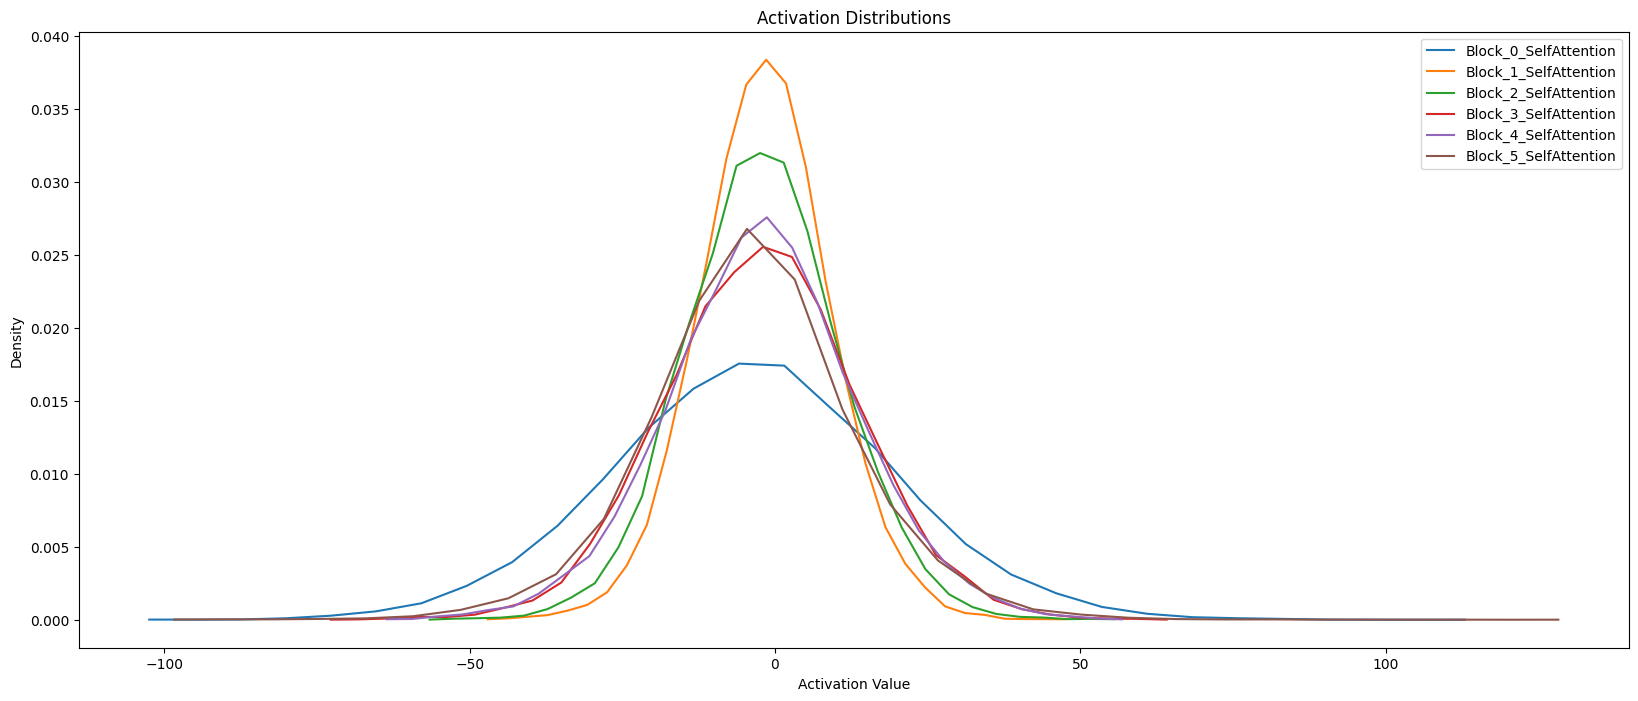

In [24]:
import matplotlib.pyplot as plt
import torch

# Hook to capture activations
activation_data = {}

def capture_activations(name):
    def hook(module, input, output):
        activation_data[name] = output.detach().cpu()
    return hook

# Register hooks to capture activations from transformer blocks
hooks = []
for i, block in enumerate(model.blocks):
    hook = block.sa.register_forward_hook(capture_activations(f"Block_{i}_SelfAttention"))
    hooks.append(hook)

# Test batch
x_test, _ = get_batch()
model.eval()
with torch.no_grad():
    _ = model(x_test)

# Plot histograms of activations
plt.figure(figsize=(20, 8))  # Adjust size as needed
legends = []
for name, activation in activation_data.items():
    mean_act = activation.mean()
    std_act = activation.std()
    #saturated = (activation.abs() > 0.97).float().mean() * 100
    saturation_threshold = activation.abs().max() * 0.97
    saturated = (activation.abs() > saturation_threshold).float().mean() * 100
    print(f"{name}: mean {mean_act:.2f}, std {std_act:.2f}, saturated: {saturated:.2f}%")

    # Compute histogram
    hy, hx = torch.histogram(activation, bins=30, density=True)
    plt.plot(hx[:-1], hy, label=name)

plt.legend()
plt.title("Activation Distributions")
plt.xlabel("Activation Value")
plt.ylabel("Density")
plt.show()

# Remove hooks after use
for hook in hooks:
    hook.remove()


Things look good overall here.

Block 0 - Layer 0 - Param heads.0.key.weight (MultiHeadAttention): Mean -0.000000, Std 9.948074e-08
Block 0 - Layer 0 - Param heads.0.query.weight (MultiHeadAttention): Mean -0.000000, Std 6.220824e-08
Block 0 - Layer 0 - Param heads.0.value.weight (MultiHeadAttention): Mean -0.000000, Std 1.158275e-04
Block 0 - Layer 0 - Param heads.1.key.weight (MultiHeadAttention): Mean -0.000000, Std 1.161585e-16
Block 0 - Layer 0 - Param heads.1.query.weight (MultiHeadAttention): Mean -0.000000, Std 1.062621e-16
Block 0 - Layer 0 - Param heads.1.value.weight (MultiHeadAttention): Mean -0.000000, Std 2.761250e-04
Block 0 - Layer 0 - Param heads.2.key.weight (MultiHeadAttention): Mean +0.000000, Std 9.314587e-11
Block 0 - Layer 0 - Param heads.2.query.weight (MultiHeadAttention): Mean -0.000000, Std 1.092873e-10
Block 0 - Layer 0 - Param heads.2.value.weight (MultiHeadAttention): Mean -0.000001, Std 2.932028e-04
Block 0 - Layer 0 - Param heads.3.key.weight (MultiHeadAttention): Mean +0.000000, Std 5

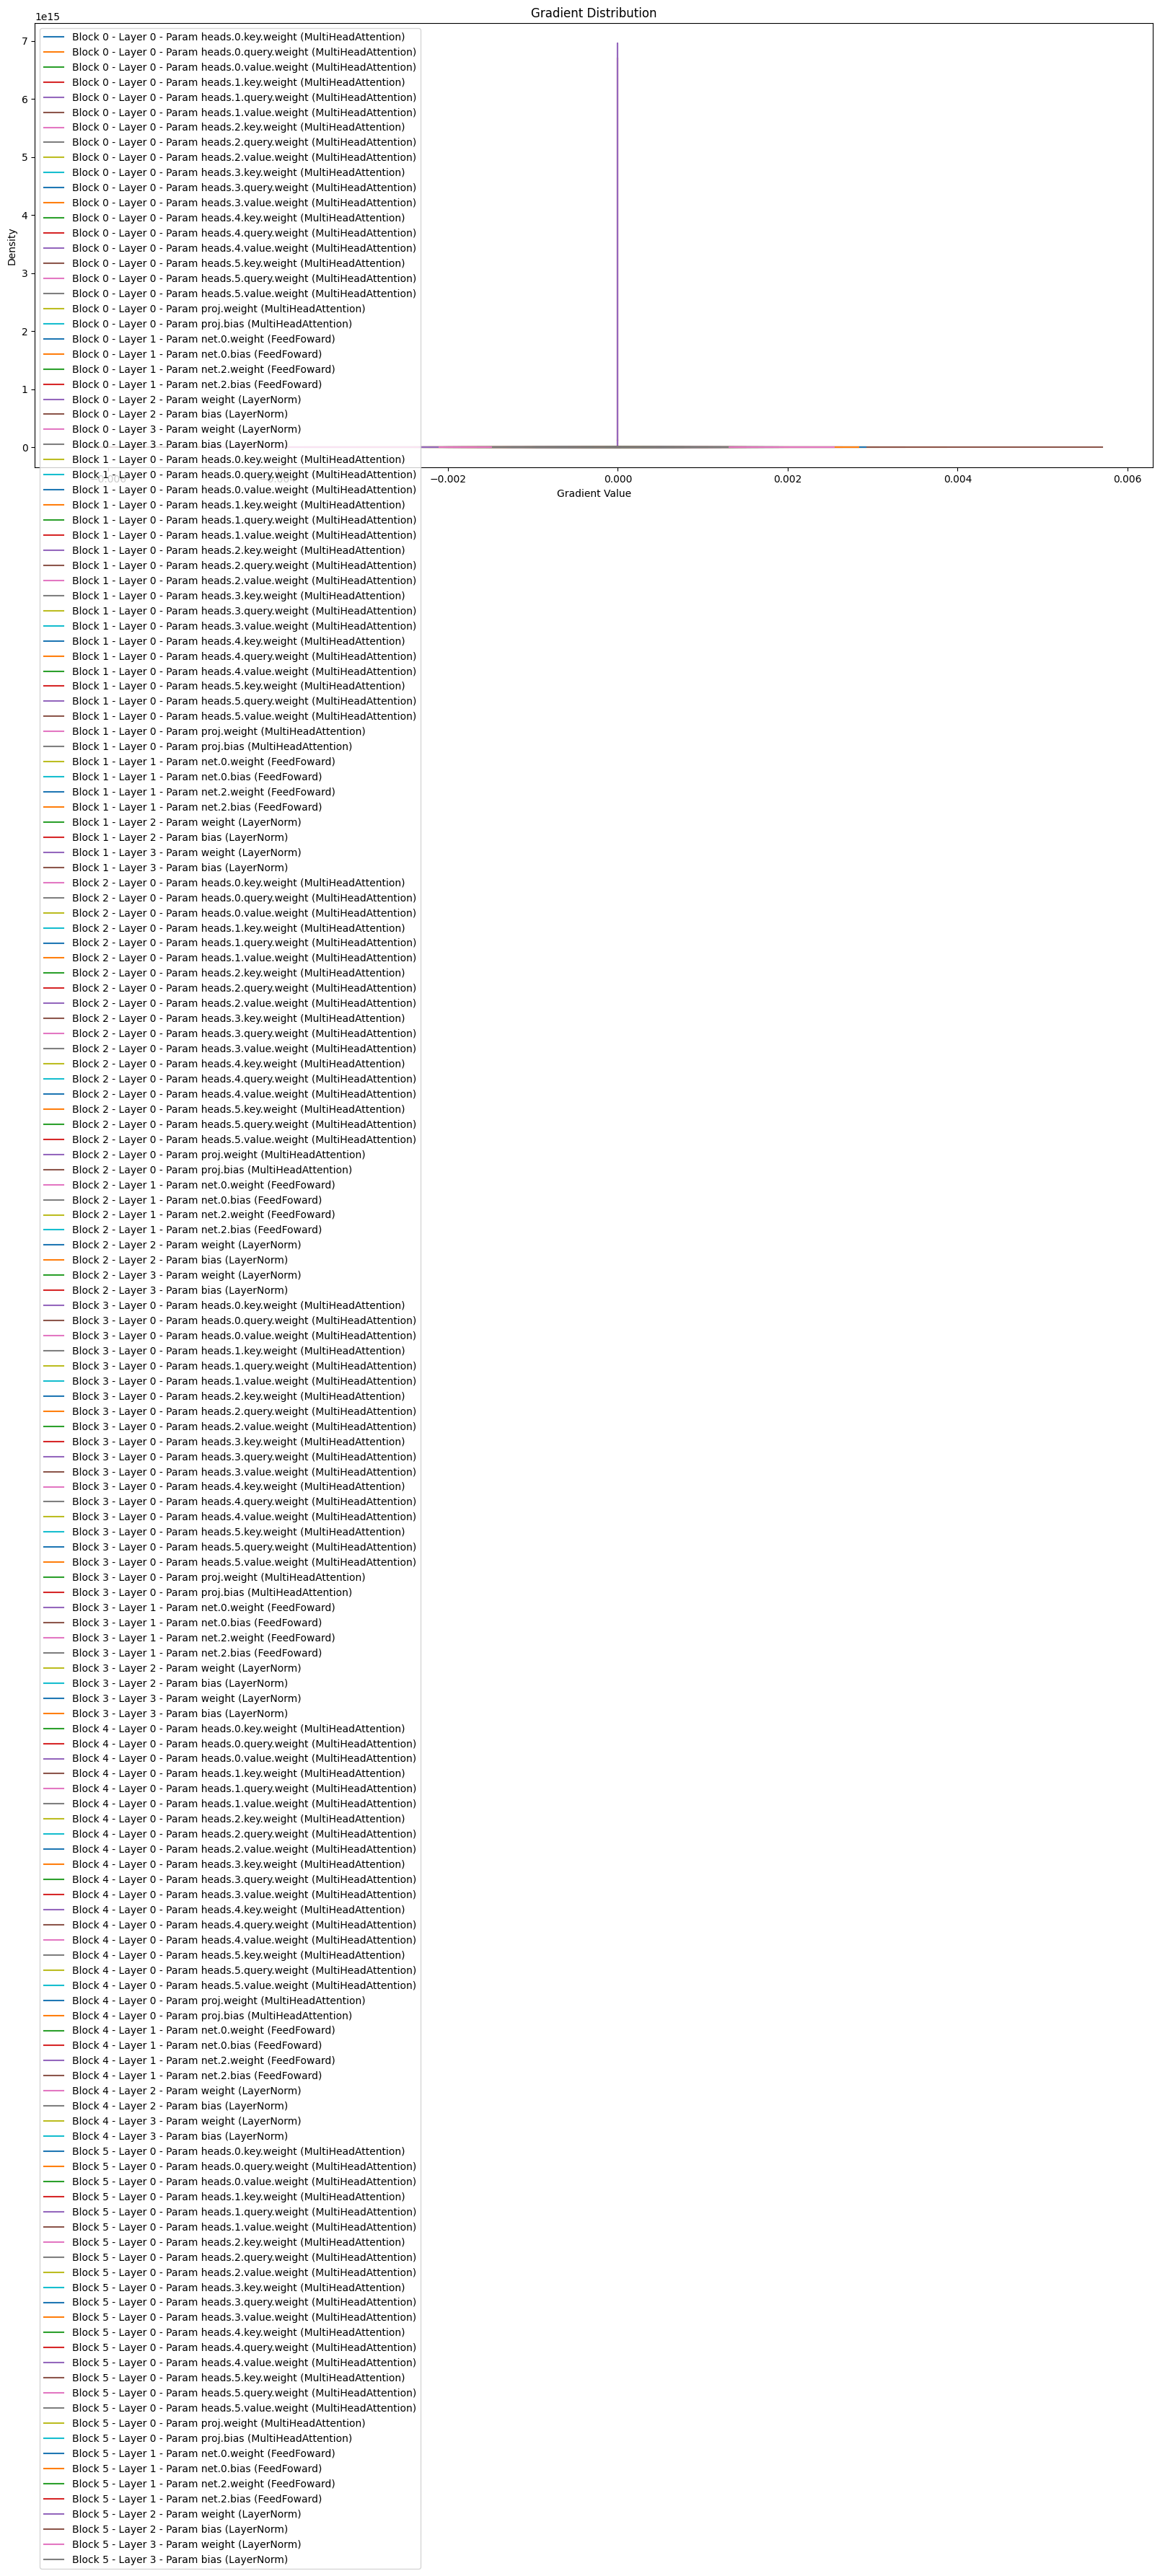

In [22]:
import matplotlib.pyplot as plt
import torch

# Set model to train mode for gradient computation
model.train()

# Perform a forward and backward pass to calculate gradients
x_test, y_test = get_batch()
optimizer.zero_grad()
_, loss = model(x_test, y_test)
loss.backward()

# Plot gradient distributions
plt.figure(figsize=(20, 8))  # Adjust size as needed
legends = []

for block_num, block in enumerate(model.blocks):
    for layer_num, layer in enumerate(block.children()):
        # Check if the layer has parameters that require gradients
        if hasattr(layer, 'parameters') and any(p.requires_grad for p in layer.parameters()):
            # Iterate through parameters in the layer
            for param_name, param in layer.named_parameters():
                if param.grad is not None:  # Ensure gradients are computed
                    grad = param.grad
                    mean_grad = grad.mean()
                    std_grad = grad.std()
                    print(
                        f"Block {block_num} - Layer {layer_num} - Param {param_name} ({layer.__class__.__name__}): "
                        f"Mean {mean_grad:+.6f}, Std {std_grad:.6e}"
                    )

                    # Compute histogram
                    hy, hx = torch.histogram(grad.cpu(), bins=30, density=True)
                    plt.plot(hx[:-1].detach(), hy.detach())
                    legends.append(f"Block {block_num} - Layer {layer_num} - Param {param_name} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradient Distribution")
plt.xlabel("Gradient Value")
plt.ylabel("Density")
plt.show()

<ipython-input-23-288b92e27588>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


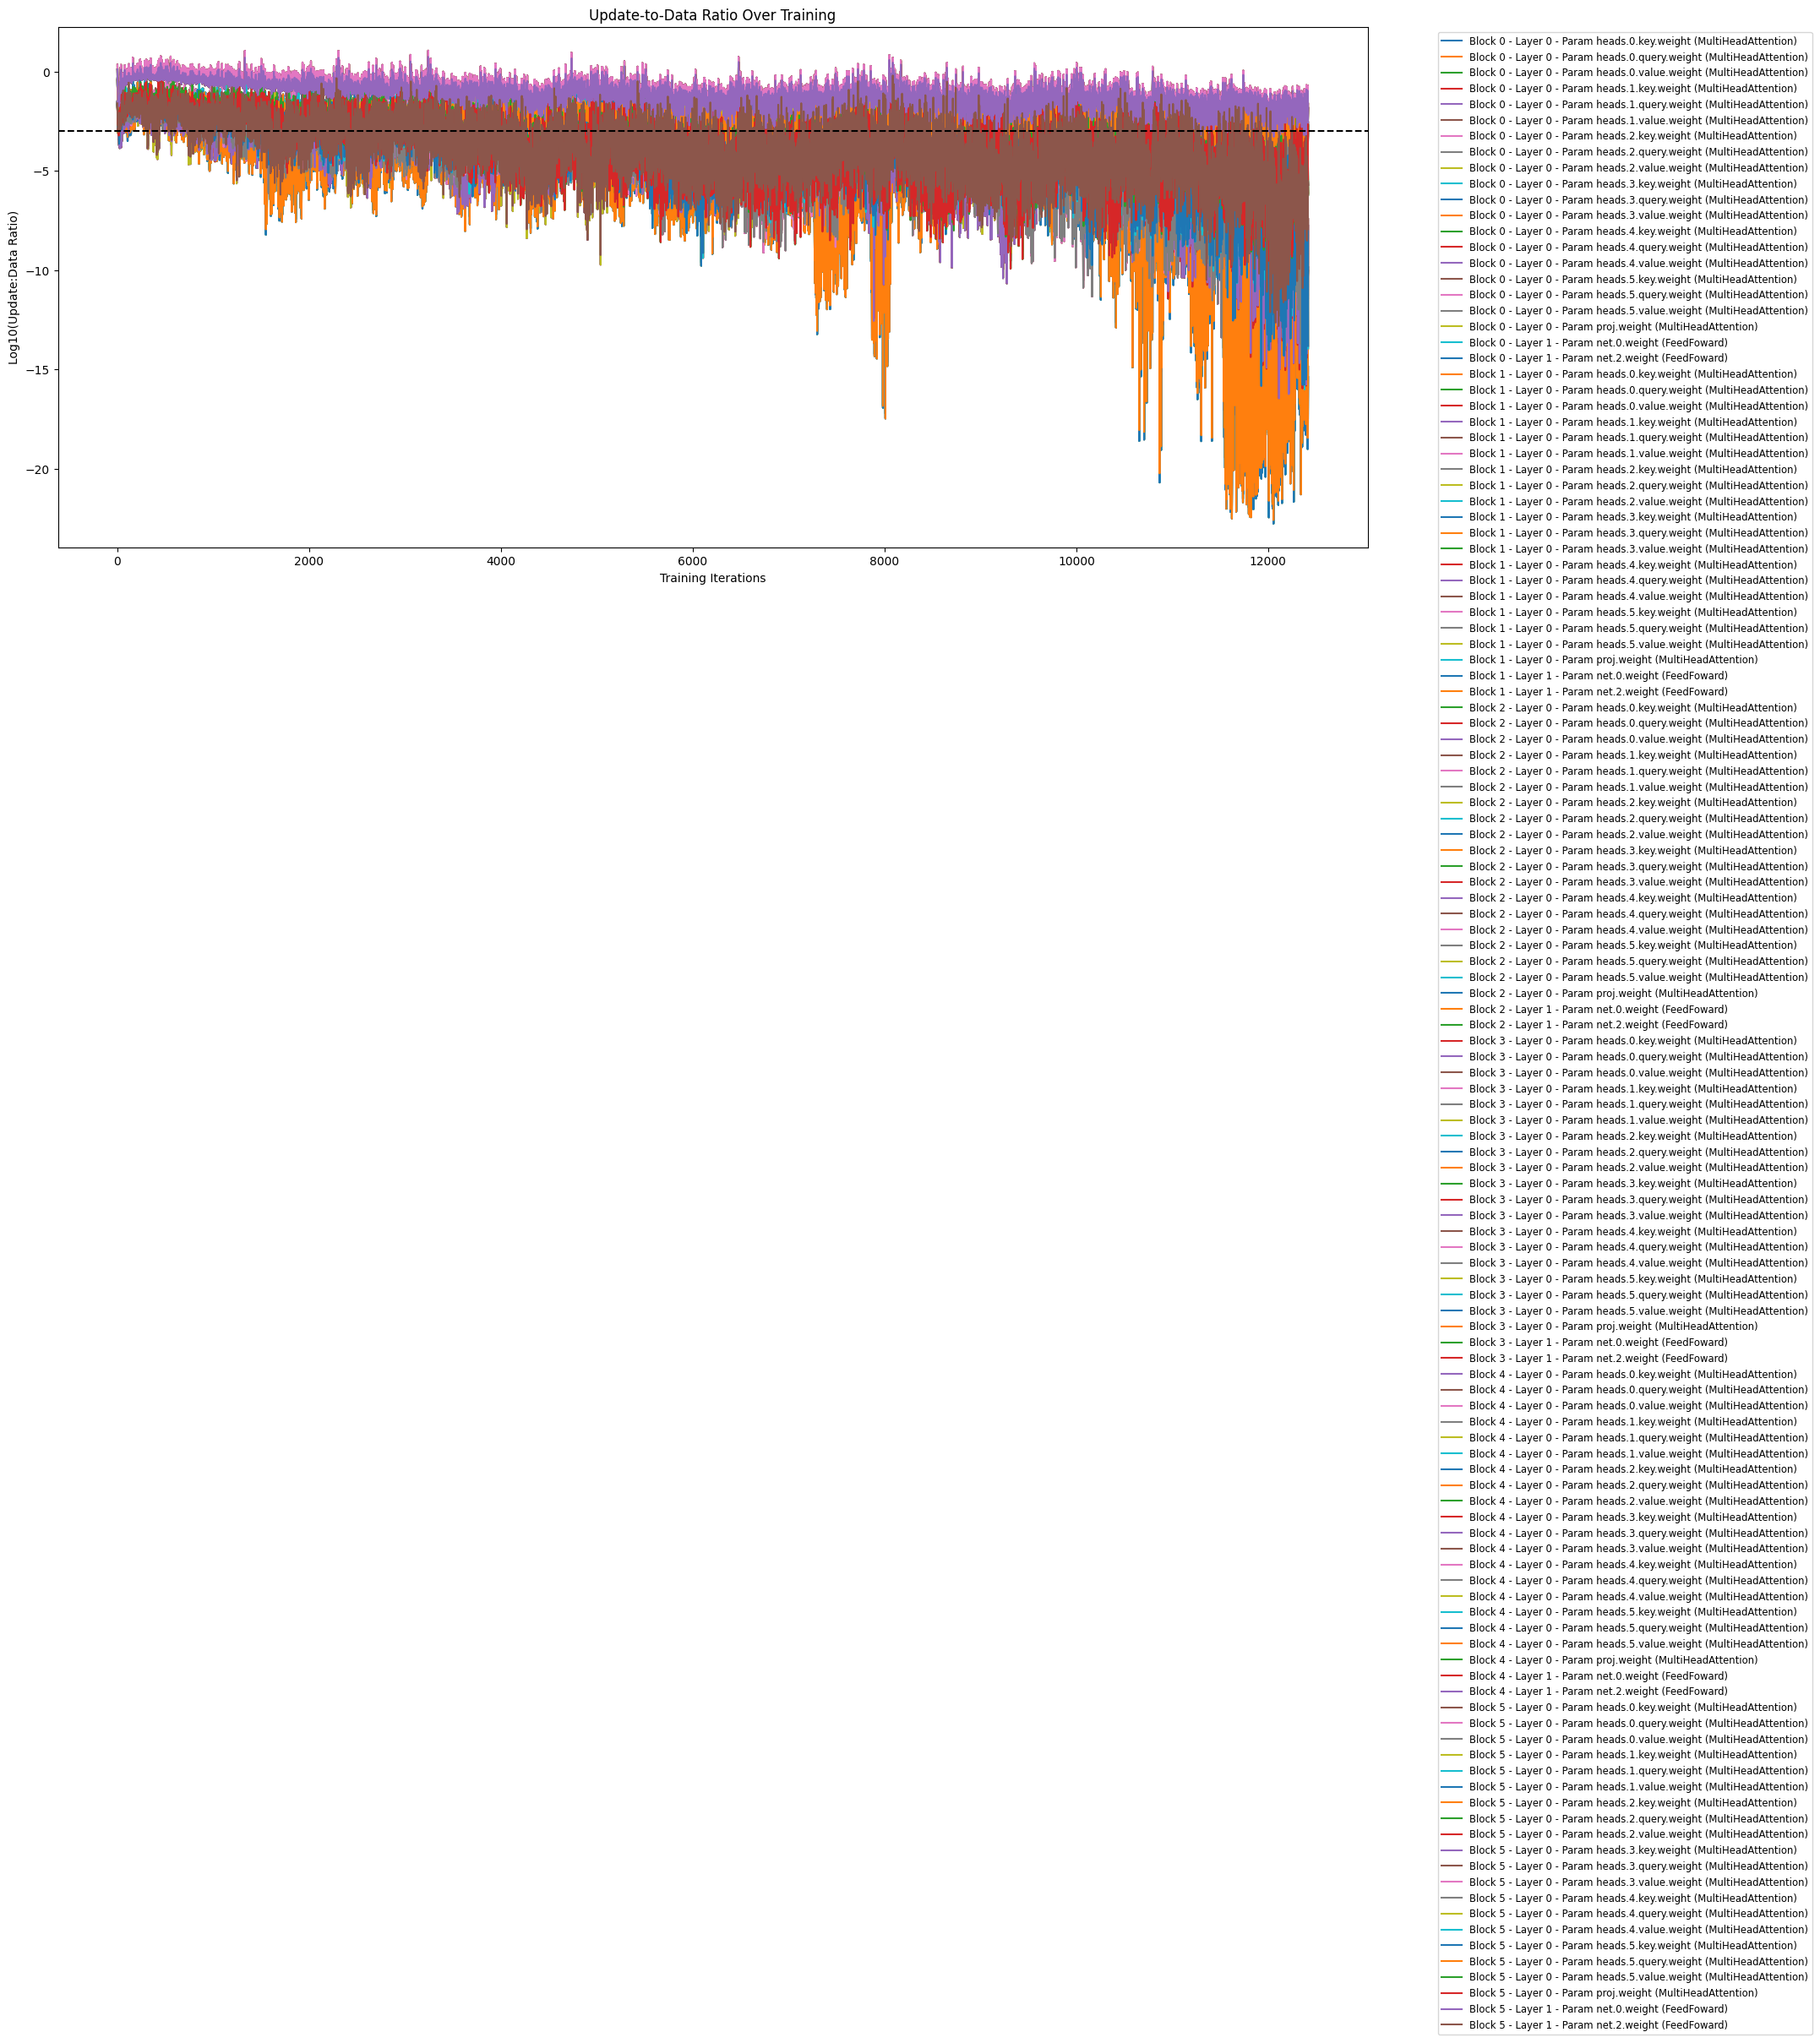

In [23]:
import matplotlib.pyplot as plt

# List to store update-to-data ratios for all parameters over training iterations
# Plot Update-to-Data Ratios
plt.figure(figsize=(20, 8))
legends = []

# Map parameter indices to their block, layer, and name for legend labels
param_idx_map = {}

for block_num, block in enumerate(model.blocks):
    for layer_num, layer in enumerate(block.children()):
        if hasattr(layer, 'parameters') and any(p.requires_grad for p in layer.parameters()):
            for param_idx, (param_name, param) in enumerate(layer.named_parameters()):
                if param.ndim == 2:  # Focus on weight matrices (2D parameters)
                    param_idx_map[len(param_idx_map)] = (block_num, layer_num, param_name, layer.__class__.__name__)

                    # Plot update-to-data ratios over iterations
                    plt.plot([ud[j][param_idx] for j in range(len(ud))])
                    legends.append(f"Block {block_num} - Layer {layer_num} - Param {param_name} ({layer.__class__.__name__})")

# Add a reference line for the typical ratio (~1e-3)
plt.axhline(y=-3, color='k', linestyle='--', label="Expected Ratio (1e-3)")

# Customize and display the plot
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize='small')  # Adjust legend position
plt.title("Update-to-Data Ratio Over Training")
plt.xlabel("Training Iterations")
plt.ylabel("Log10(Update:Data Ratio)")
plt.tight_layout()
plt.show()

Yikes.

#### EX3

#### EX4